##  Multi-Modal DNN

The goal of this notebook is to explore multi-modal DNN model [1] as it applies to App intent classification (e.g. work vs play or commercial vs personal app usage) based on multi-modal inputs: URLs and Apps.

An additional goal is to build on top of intent classification in order for App to know more about its session, e.g. session type, current session length and be able to predict session endtime and next session type.

Let's start by importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
from keras import Input
from keras.layers import Dense, concatenate, Dropout
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

from tqdm import tqdm

Using TensorFlow backend.


In [3]:
def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 4.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

In [4]:
class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

Let's start by exploring the dataset

In [5]:
data_df = pd.read_csv('./data/audit_risk.csv')
data_df.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [6]:
row_idx_to_drop = np.where(~data_df['LOCATION_ID'].str.isnumeric())
print("droping non-numerical data, row idx: ", row_idx_to_drop[0].tolist())
data_df.drop(row_idx_to_drop[0].tolist(), inplace=True)

droping non-numerical data, row idx:  [351, 355, 367]


For the purpose of creating a multi-input dataset, let's split the dataframe into two based on column names: data_df2 will contain columns with the name "risk" and data_df1 will contain the remaining columns.

In [7]:
column_names = list(map(str.lower, list(data_df.columns.values)))
column1_idx = ['risk' in item for item in column_names]
column2_idx = [not item for item in column1_idx]
df1_col = np.where(column1_idx)[0]
df2_col = np.where(column2_idx)[0]
data_df1 = data_df.iloc[:,df1_col]
data_df2 = data_df.iloc[:,df2_col]

In [8]:
y = data_df1['Risk'].values #binary target variable

X1 = data_df1.drop(columns=['Risk']).astype('float64').values #input1
X2 = data_df2.astype('float64').values #input2

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.1, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.1, random_state=0)

In [9]:
num_features1 = X1_train.shape[1]
num_features2 = X2_train.shape[1]
print("number of features (input 1): ", num_features1)
print("number of training examples (input 1): ", X1_train.shape[0])
print("number of features (input 2): ", num_features2)
print("number of training examples (input 2): ", X2_train.shape[0])

number of features (input 1):  10
number of training examples (input 1):  695
number of features (input 2):  16
number of training examples (input 2):  695


We can see that the dataset target label (risk) is relatively balanced. Also, the number of training examples is somewhat low for a neural net based model, however, it's interesting to see how it'll perform in this data-limited regime.

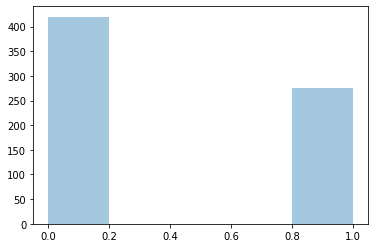

In [10]:
sns.distplot(y1_train, kde=False)

Next, let's define our multi-modal NN using the functional keras API

In [11]:
#training params
batch_size = 64
num_epochs = 32

In [12]:
#model parameters
hidden_size = 8 

dense_dropout = 0.2
weight_decay = 1e-4

In [13]:
#multi-modal MLP
input1 = Input(shape=(num_features1,), name='app')
x = Dense(num_features1, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(input1)
x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)

input2 = Input(shape=(num_features2,), name='url')
y = Dense(num_features2, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(input2)
y = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(y)

merged = concatenate([x, y], axis=-1)
z = Dropout(dense_dropout)(merged)
z = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(z)
output = Dense(1, activation='sigmoid')(z)

model=Model([input1, input2], output)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

W0729 11:04:16.091658 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 11:04:16.116804 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 11:04:16.121865 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 11:04:16.216422 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorfl

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                (None, 10)           0                                            
__________________________________________________________________________________________________
url (InputLayer)                (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           110         app[0][0]                        
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           272         url[0][0]                        
__________________________________________________________________________________________________
dense_2 (D

In [14]:
#define callbacks
SAVE_PATH = "./data"
file_name = SAVE_PATH + 'dnn-weights-checkpoint.h5'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=16, verbose=1)
callbacks_list = [checkpoint, tensor_board, hist_lr, reduce_lr, early_stopping]

In [15]:
#hist = model.fit({'app': X1_train, 'url': X2_train}, y1_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_data=({'app':X1_test, 'url':X2_test}, y1_test), shuffle=True, verbose=1)
hist = model.fit([X1_train, X2_train], y1_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=1)

Train on 625 samples, validate on 70 samples


W0729 11:04:18.206488 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0729 11:04:18.206488 24536 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/32
625/625 [==============================] - ETA: 3s - loss: 2.8739 - acc: 0.593 - 0s 739us/step - loss: 2.0219 - acc: 0.6032 - val_loss: nan - val_acc: 0.6429

Epoch 00001: val_loss did not improve from inf
Epoch 2/32
625/625 [==============================] - ETA: 0s - loss: 1.0940 - acc: 0.703 - 0s 35us/step - loss: 1.0863 - acc: 0.6784 - val_loss: nan - val_acc: 0.7714

Epoch 00002: val_loss did not improve from inf
Epoch 3/32
625/625 [==============================] - ETA: 0s - loss: 0.7795 - acc: 0.750 - 0s 36us/step - loss: 0.6842 - acc: 0.7472 - val_loss: nan - val_acc: 0.8429

Epoch 00003: val_loss did not improve from inf
Epoch 4/32
625/625 [==============================] - ETA: 0s - loss: 0.6643 - acc: 0.750 - 0s 48us/step - loss: 0.5993 - acc: 0.7328 - val_loss: nan - val_acc: 0.8857

Epoch 00004: val_loss did not improve from inf
Epoch 5/32
625/625 [==============================] - ETA: 0s - loss: 0.5711 - acc: 0.734 - 0s 35us/step - loss: 0.5577 - acc: 0.7648 -

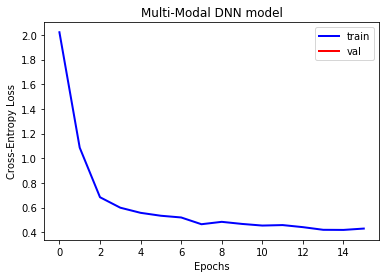

In [16]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_loss'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('./figures/dnn_loss.png')

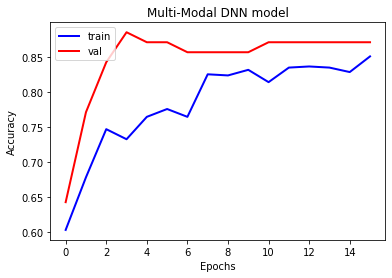

In [17]:
plt.figure()
plt.plot(hist.history['acc'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_acc'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('./figures/dnn_acc.png')

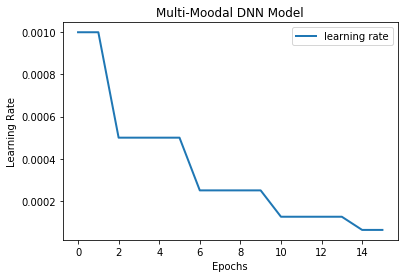

In [18]:
plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('Multi-Moodal DNN Model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/dnn_learning_rate.png')

In [19]:
#plot_model(model, show_shapes=True, to_file='./figures/dnn_model.png')

### References

[1] Francois Chollet, "Deep Learning with Python", 2017 